In [66]:
# Load Packages

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline             
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
import shap
from collections import Counter


# Load Dataset

In [2]:

df = pd.read_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/OnlyNormalized_volumes(CS).csv")

df = df[df["group"] != "Control"]

In [3]:

# Binary labelLing
# Control -> 0, PD-NC  -> 1
df["label"] = df["group"].apply(lambda x: 0 if x == "PD-NC" else 1)

# Drop non-feature columns
X = df.drop(columns=["Subjects", "group", "label"])
y = df["label"]


In [4]:
# Check the number of Healthy and PD-NC(Parkinson's with normal cognition)
df["group"].value_counts()

group
PD-NC     18
PD-MCI    15
Name: count, dtype: int64

# Feature Selection

In [5]:
# Drop non-feature columns
X = df.drop(columns=['Subjects','Unnamed: 0','group','label'])
y = df["label"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [7]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k=10)),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

pipe.fit(X_train, y_train)


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,steps,"[('scaler', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,score_func,<function f_c...x706681f04e50>
,k,10
,penalty,'l2'
,dual,False


In [8]:
selected_features_LR = X.columns[pipe.named_steps["selector"].get_support()]
print(selected_features_LR)


Index(['norm_Left-Lateral-Ventricle', 'norm_Left-Inf-Lat-Vent',
       'norm_3rd-Ventricle', 'norm_4th-Ventricle', 'norm_Brain-Stem',
       'norm_Right-Lateral-Ventricle', 'norm_Right-Inf-Lat-Vent',
       'norm_Right-Cerebellum-White-Matter', 'norm_Right-Caudate',
       'norm_Right-vessel'],
      dtype='object')


In [9]:
## Embedded methods (L1-regularized Logistic Regression)
pipe_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=1000
    ))
])

pipe_l1.fit(X_train, y_train)


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0


In [10]:
coef = pipe_l1.named_steps["clf"].coef_[0]
selected_features_LASSO = X.columns[coef != 0]

print("Selected features:", selected_features_LASSO)


Selected features: Index(['norm_Left-Inf-Lat-Vent', 'norm_4th-Ventricle', 'norm_Brain-Stem',
       'norm_CSF', 'norm_Left-vessel', 'norm_Right-Lateral-Ventricle',
       'norm_Right-Thalamus', 'norm_Right-Caudate', 'norm_Right-Pallidum',
       'norm_Right-vessel', 'norm_CC_Mid_Anterior',
       'norm_rhCerebralWhiteMatterVol'],
      dtype='object')


In [11]:
# Tree-based feature importance 

rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
SELECTED_FEATURES_RF = importances.sort_values(ascending=False).head(10)

In [12]:
# Wrapper methods

from sklearn.feature_selection import RFE

rfe = RFE(
    estimator=LogisticRegression(
        class_weight="balanced",
        max_iter=500
    ),
    n_features_to_select=10
)

rfe.fit(X_train, y_train)

selected_features_RFE = X.columns[rfe.support_]


In [13]:

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(f_classif, k=10)),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    X,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("Mean ROC-AUC:", scores.mean())


Mean ROC-AUC: 0.6944444444444444


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] 

In [14]:
selected_features_rfe = selected_features_RFE.tolist()
selected_features_lasso = selected_features_LASSO.tolist()
selected_features_lr = selected_features_LR.tolist()
selected_features_rf = SELECTED_FEATURES_RF.index.tolist()


type(selected_features_rfe), type(selected_features_lasso), type(selected_features_lr), type(selected_features_rf)

final_selected_features = selected_features_rfe + selected_features_lasso + selected_features_lr + selected_features_rf 
final_selected_features = set(final_selected_features)
# final_selected_features.remove("Unnamed: 0")

In [15]:
df_list = df.columns.values.tolist()
len(df_list)
drop_features = set(df_list) - set(final_selected_features)
drop_features.remove("Unnamed: 0")
len(drop_features), len(final_selected_features), len(df_list)

(39, 23, 63)

# Training with the classification  model

In [16]:
# Drop the columns not in drop_features list
X = df.drop(columns=['Subjects','Unnamed: 0','group','label','norm_3rd-Ventricle', 'norm_CC_Central', 'norm_CC_Mid_Posterior',
                     'norm_CortexVol', 'norm_Left-Amygdala', 'norm_Left-Cerebellum-White-Matter', 'norm_Left-Inf-Lat-Vent', 
                     'norm_Left-Lateral-Ventricle', 'norm_Left-Pallidum', 'norm_Left-VentralDC', 'norm_Left-WM-hypointensities', 
                     'norm_Left-choroid-plexus', 'norm_Left-non-WM-hypointensities', 'norm_Left-vessel', 'norm_Right-Accumbens-area', 
                     'norm_Right-Amygdala', 'norm_Right-Cerebellum-Cortex', 'norm_Right-Cerebellum-White-Matter', 'norm_Right-Hippocampus',
                     'norm_Right-Lateral-Ventricle', 'norm_Right-Pallidum', 'norm_Right-Putamen', 'norm_Right-VentralDC', 
                     'norm_Right-WM-hypointensities', 'norm_Right-choroid-plexus', 'norm_Right-non-WM-hypointensities', 'norm_TotalGrayVol', 
                     'norm_WM-hypointensities', 'norm_lhCortexVol', 'norm_non-WM-hypointensities', 'norm_rhCortexVol'])
y = df["label"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [18]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
    ]),

    "SVM (RBF)": Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
    ]),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ),

    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        random_state=42
    ),

    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),

    "Bagging": BaggingClassifier(
        n_estimators=100,
        random_state=42
    )
}


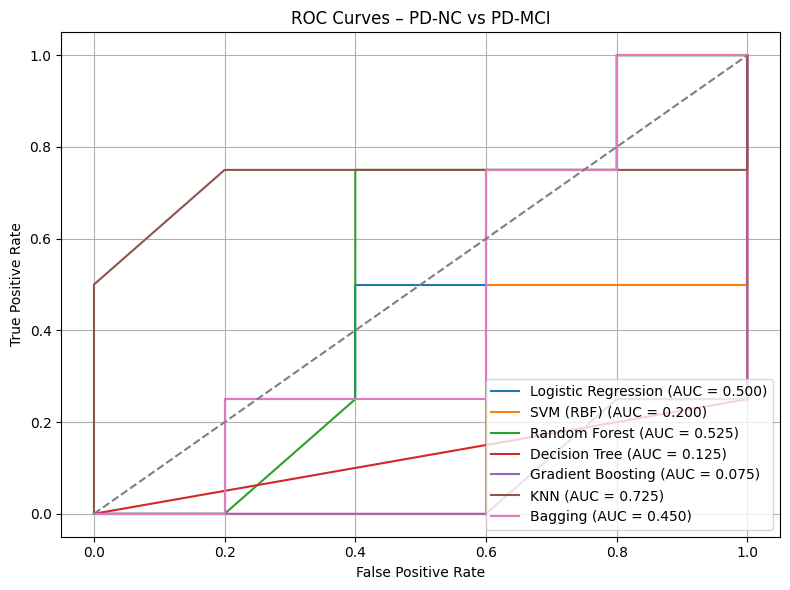

In [19]:
results = []

plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    results.append({
    "Model": name,
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "F1-score": f1_score(y_test, y_pred)
    })

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")


results_df = pd.DataFrame(results)


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – PD-NC vs PD-MCI")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Voting Classifier Results
Accuracy: 0.4444444444444444
ROC-AUC: 0.45
F1-score: 0.2857142857142857


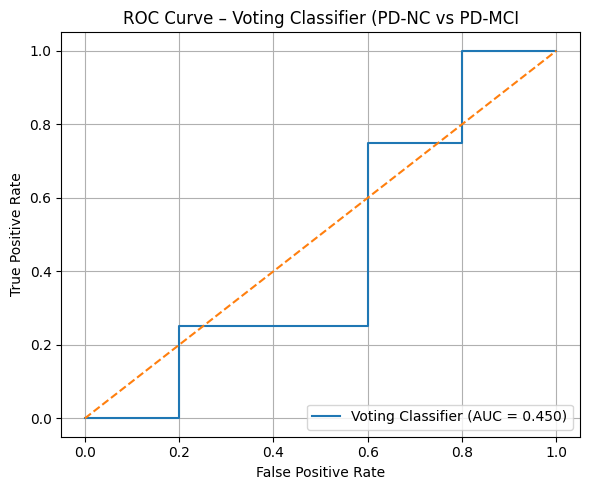

In [20]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", models["Logistic Regression"]),
        ("rf", models["Random Forest"]),
        ("svm", models["SVM (RBF)"])
    ],
    voting="soft"
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

print("Voting Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("F1-score:", f1_score(y_test, y_pred))

# Get ROC values
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Voting Classifier (PD-NC vs PD-MCI")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Model: Logistic Regression


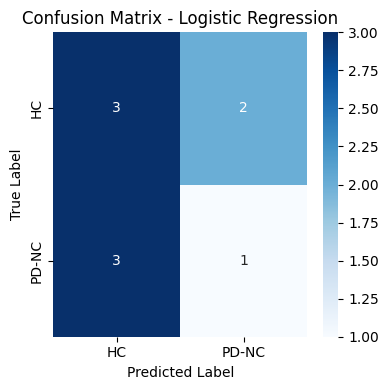


Classification Report - Logistic Regression
              precision    recall  f1-score   support

          HC       0.50      0.60      0.55         5
       PD-NC       0.33      0.25      0.29         4

    accuracy                           0.44         9
   macro avg       0.42      0.42      0.42         9
weighted avg       0.43      0.44      0.43         9

Model: SVM (RBF)


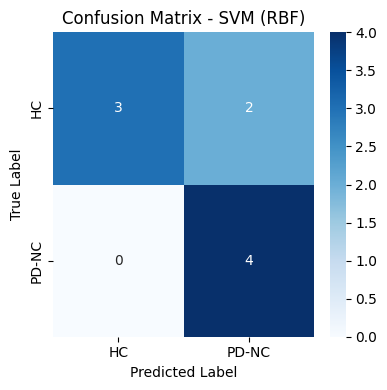


Classification Report - SVM (RBF)
              precision    recall  f1-score   support

          HC       1.00      0.60      0.75         5
       PD-NC       0.67      1.00      0.80         4

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.78         9
weighted avg       0.85      0.78      0.77         9

Model: Random Forest


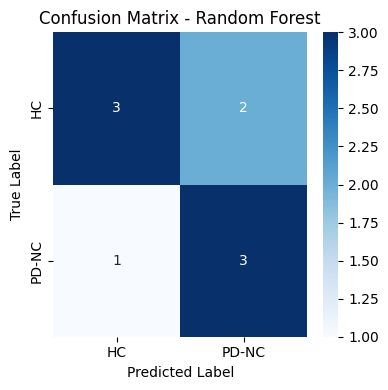


Classification Report - Random Forest
              precision    recall  f1-score   support

          HC       0.75      0.60      0.67         5
       PD-NC       0.60      0.75      0.67         4

    accuracy                           0.67         9
   macro avg       0.68      0.68      0.67         9
weighted avg       0.68      0.67      0.67         9

Model: Decision Tree


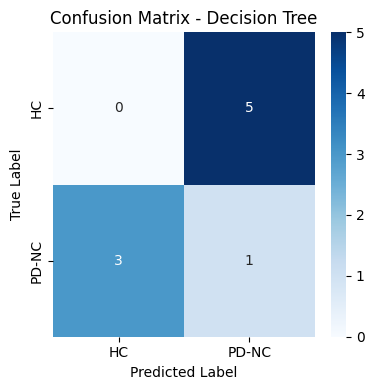


Classification Report - Decision Tree
              precision    recall  f1-score   support

          HC       0.00      0.00      0.00         5
       PD-NC       0.17      0.25      0.20         4

    accuracy                           0.11         9
   macro avg       0.08      0.12      0.10         9
weighted avg       0.07      0.11      0.09         9

Model: Gradient Boosting


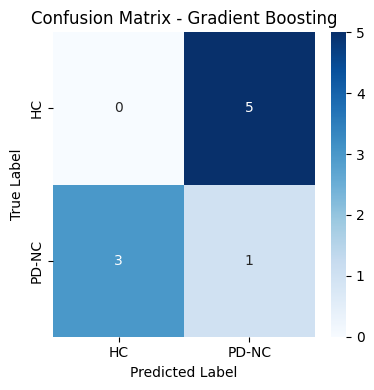


Classification Report - Gradient Boosting
              precision    recall  f1-score   support

          HC       0.00      0.00      0.00         5
       PD-NC       0.17      0.25      0.20         4

    accuracy                           0.11         9
   macro avg       0.08      0.12      0.10         9
weighted avg       0.07      0.11      0.09         9

Model: KNN


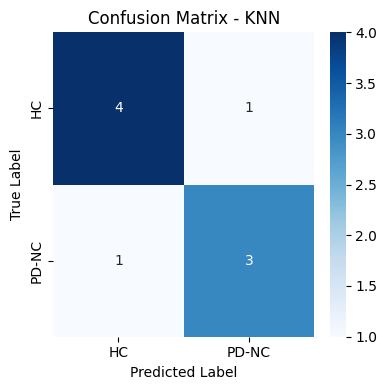


Classification Report - KNN
              precision    recall  f1-score   support

          HC       0.80      0.80      0.80         5
       PD-NC       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9

Model: Bagging


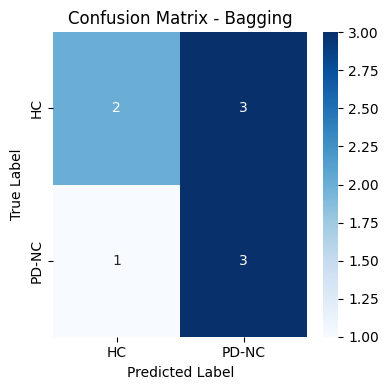


Classification Report - Bagging
              precision    recall  f1-score   support

          HC       0.67      0.40      0.50         5
       PD-NC       0.50      0.75      0.60         4

    accuracy                           0.56         9
   macro avg       0.58      0.57      0.55         9
weighted avg       0.59      0.56      0.54         9



In [21]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Prints confusion matrix and classification report
    """
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["HC", "PD-NC"],
        yticklabels=["HC", "PD-NC"]
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\nClassification Report - {model_name}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["HC", "PD-NC"]
    ))

for name, model in models.items():
    print("=" * 60)
    print(f"Model: {name}")

    model.fit(X_train, y_train)
    evaluate_model(model, name, X_test, y_test)


# Stratified Cross Validation on the model

Mean AUC score : 0.6888888888888889


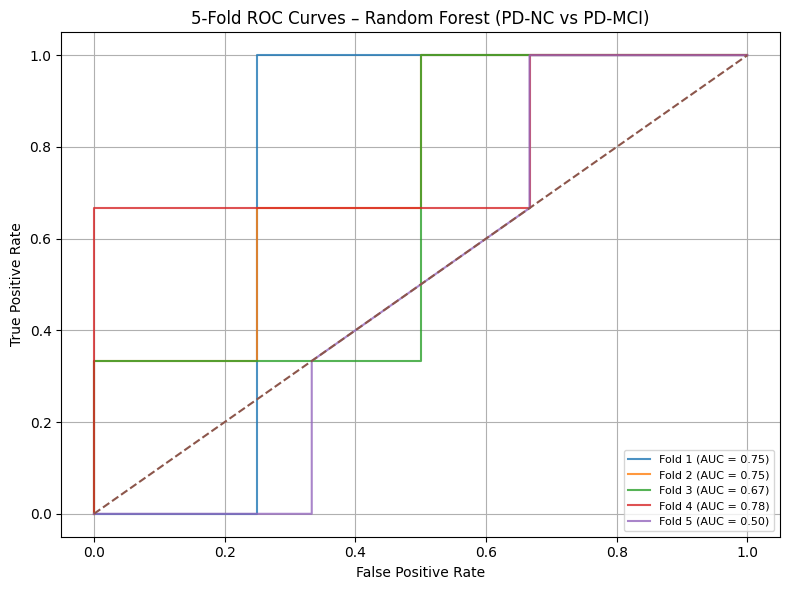

In [22]:
# Random  Forest

plt.figure(figsize=(8, 6))

aucs_RF = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["Random Forest"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_RF.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

print("Mean AUC score :", np.mean(aucs_RF))

plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Random Forest (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


Mean AUC score : 0.5166666666666666


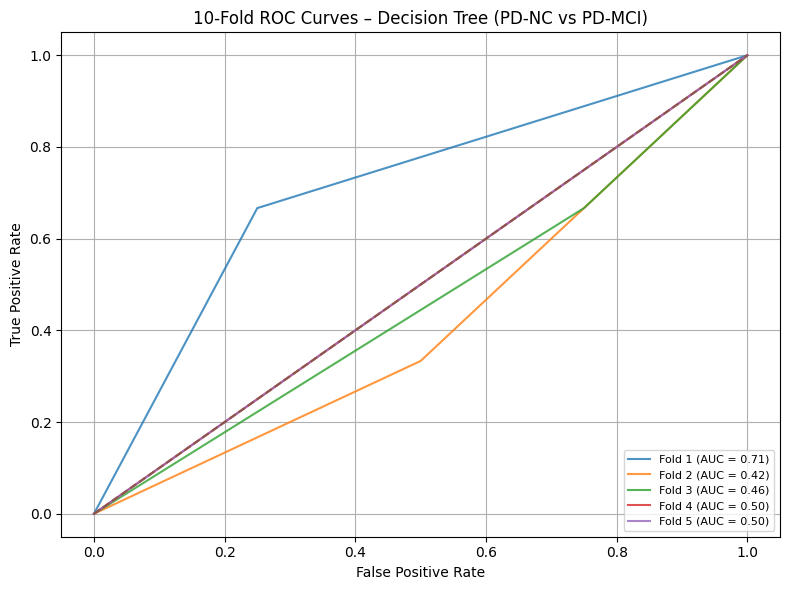

In [23]:
# Decision Tree

plt.figure(figsize=(8, 6))

aucs_DT = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["Decision Tree"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_DT.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

print("Mean AUC score :", np.mean(aucs_DT))
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("10-Fold ROC Curves – Decision Tree (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


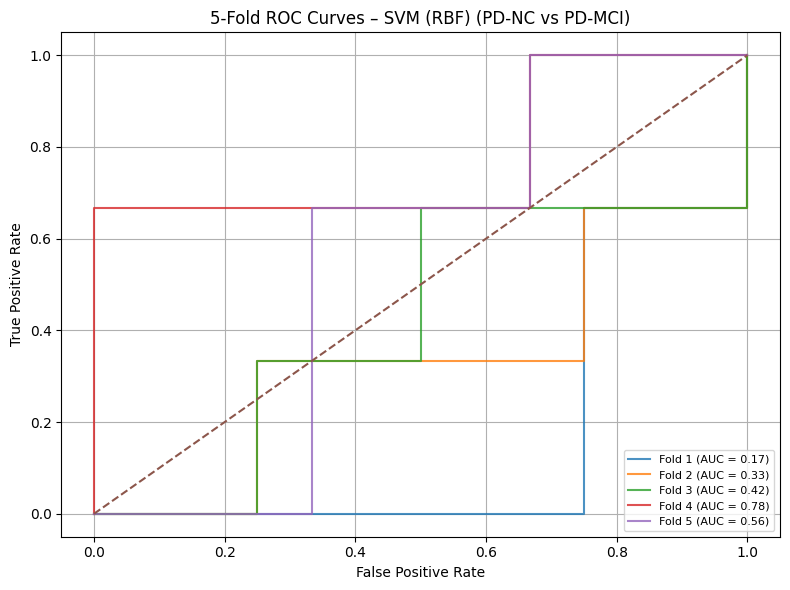

In [24]:
plt.figure(figsize=(8, 6))

aucs_SVM = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["SVM (RBF)"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_SVM.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – SVM (RBF) (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
print("Mean AUC score :", np.mean(aucs_SVM))

Mean AUC score : 0.45


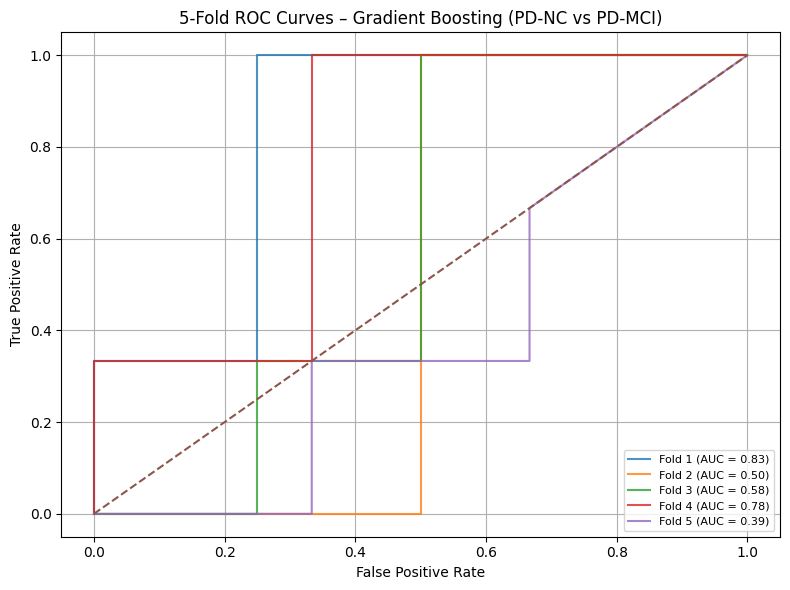

In [26]:
# Gradient Boosting

plt.figure(figsize=(8, 6))

aucs_GB = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    model = models["Gradient Boosting"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_GB.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Gradient Boosting (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
print("Mean AUC score :", np.mean(aucs_GB))

Mean AUC score : 0.6166666666666667


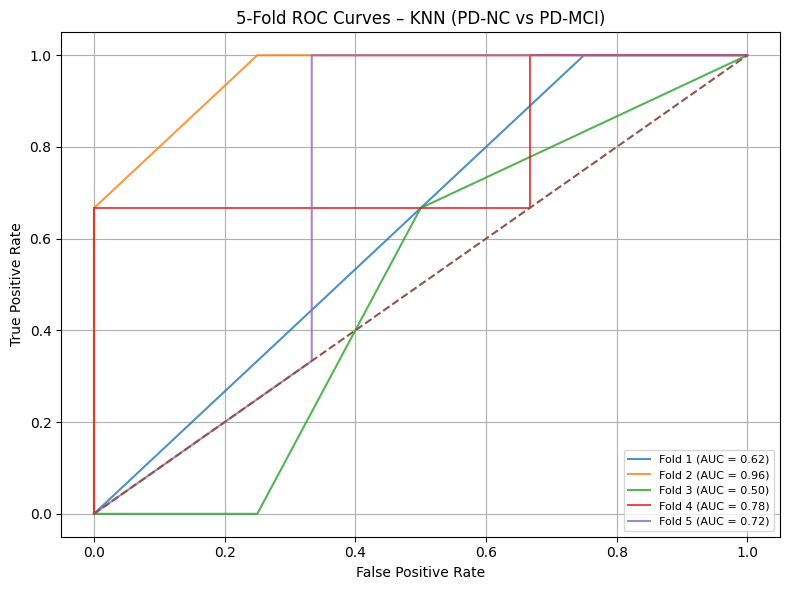

In [28]:
plt.figure(figsize=(8, 6))

aucs_knn = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["KNN"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_knn.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – KNN (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
print("Mean AUC score :", np.mean(aucs_knn))

Mean AUC score : 0.7166666666666666


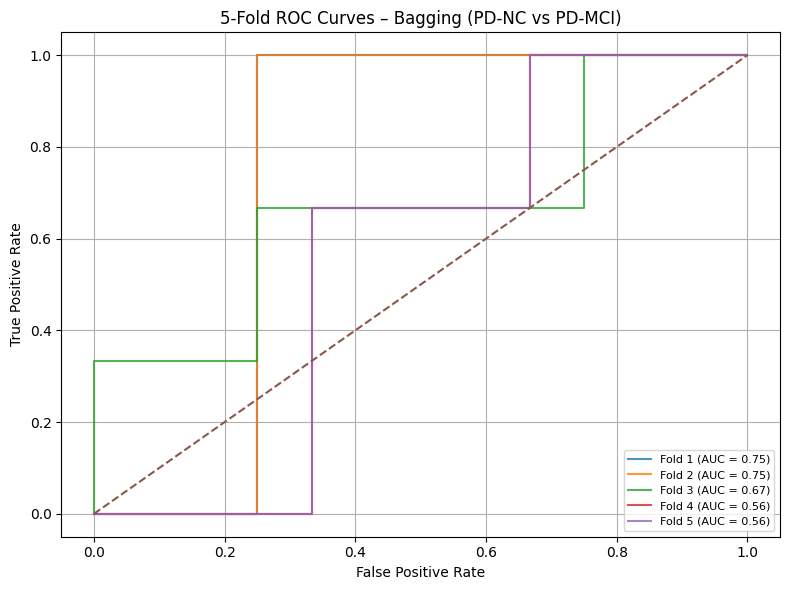

In [30]:
# Bagging

plt.figure(figsize=(8, 6))

aucs_bagging = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["Bagging"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_bagging.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Bagging (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
print("Mean AUC score :", np.mean(aucs_bagging))

Mean AUC score : 0.6555555555555556


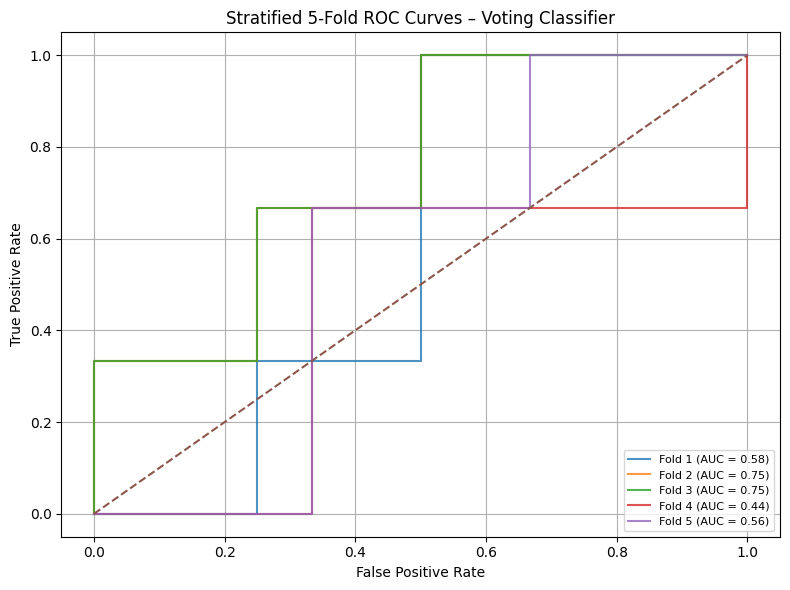

In [34]:
# Voting Classifier

plt.figure(figsize=(8, 6))

aucs = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # IMPORTANT: clone to avoid information leakage
    model = clone(voting_clf)
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stratified 5-Fold ROC Curves – Voting Classifier")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
print("Mean AUC score :", np.mean(aucs))

Mean AUC score : 0.6166666666666668


# Tune the models with nested cross-validation and SHAP for feature importance

                                                  ############   SVM  ###########

In [36]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])


In [37]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", 0.01, 0.1, 1]
}
aucs_svm = []

shap_values_per_fold_SVM = []        # aggregated SHAP
feature_names_per_fold_SVM = []
X_train_scaled_per_fold_SVM = []

plt.figure(figsize=(8, 6))


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 105.44it/s]


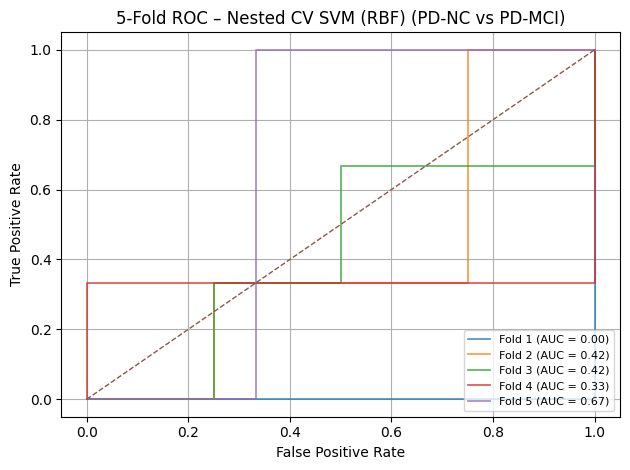

SVM Mean AUC: 0.367 ± 0.215


In [38]:
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=pipe_svm,
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_svm = grid.best_estimator_

    # ---------- ROC ----------
    y_prob = best_svm.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_svm.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

    # ---------- SHAP ----------
    X_train_scaled = best_svm.named_steps["scaler"].transform(X_train)

    background = shap.sample(
        X_train_scaled,
        min(50, X_train_scaled.shape[0]),
        random_state=42
    )

    explainer = shap.KernelExplainer(
        best_svm.named_steps["clf"].predict_proba,
        background
    )

    # explain only small subset (IMPORTANT)
    X_explain = X_train_scaled[:min(20, X_train_scaled.shape[0])]

    shap_vals = explainer.shap_values(X_explain, nsamples=100)

    # positive class
    shap_vals = shap_vals[1]    # (n_samples, n_features)

    shap_values_per_fold_SVM.append(shap_vals)
    feature_names_per_fold_SVM.append(X.columns.to_numpy())
    X_train_scaled_per_fold_SVM.append(X_train_scaled)

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV SVM (RBF) (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"SVM Mean AUC: {np.mean(aucs_svm):.3f} ± {np.std(aucs_svm):.3f}")


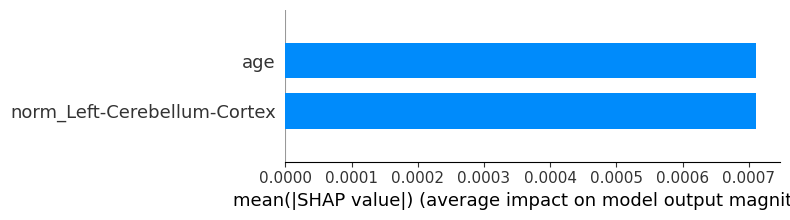

In [39]:
fold_id = 0

mean_abs_shap = np.mean(
    np.abs(shap_values_per_fold_SVM[fold_id]),
    axis=0
)

shap.summary_plot(
    mean_abs_shap.reshape(1, -1),
    features=None,
    feature_names=feature_names_per_fold_SVM[fold_id],
    plot_type="bar",
    max_display=20,
    show=True
)


In [42]:
top_features_svm = []

for fold_shap, fold_features in zip(
        shap_values_per_fold_SVM,
        feature_names_per_fold_SVM):

    mean_abs = np.mean(np.abs(fold_shap), axis=0)

    top_idx = np.argsort(mean_abs)[-10:]

    top_features_svm.extend(fold_features[top_idx])

Counter(top_features_svm)


Counter({'norm_Left-Cerebellum-Cortex': 5, 'age': 5})

                        #####   Random Forest  ###########

In [43]:
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)


In [44]:
rf_base = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", 0.3, 0.5]
}


In [45]:
aucs_rf = []

shap_values_per_fold_rf = []
X_train_per_fold_rf = []
feature_names_rf = X.columns.to_numpy()


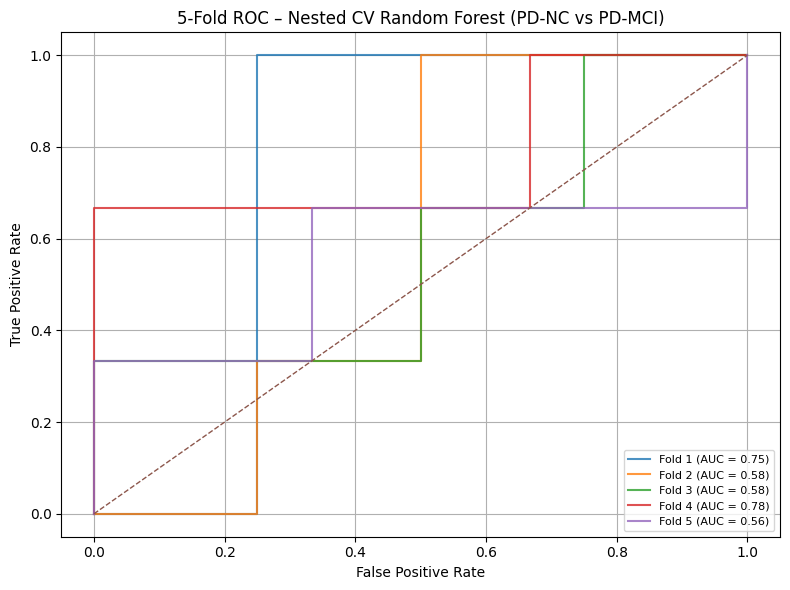

Random Forest Mean AUC: 0.650 ± 0.094


In [46]:
plt.figure(figsize=(8, 6))

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(rf_base),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_rf = grid.best_estimator_

    # ===== SHAP (TreeExplainer is exact for RF) =====
    explainer = shap.TreeExplainer(best_rf)
    shap_vals = explainer.shap_values(X_train)
    shap_vals = shap_vals[1]   # PD-MCI class

    shap_values_per_fold_rf.append(shap_vals)
    X_train_per_fold_rf.append(X_train)

    # ===== ROC =====
    y_prob = best_rf.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_rf.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Random Forest (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Random Forest Mean AUC: {np.mean(aucs_rf):.3f} ± {np.std(aucs_rf):.3f}")


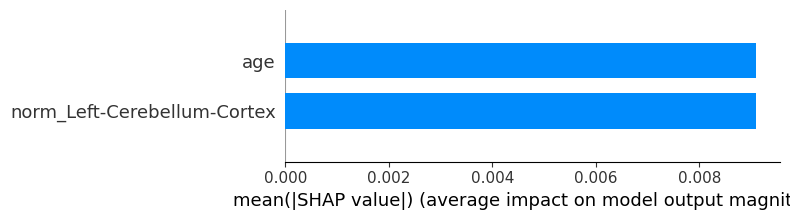

In [47]:
fold_id = 2

shap.summary_plot(
    shap_values_per_fold_rf[fold_id],
    features=None,
    feature_names=feature_names_rf,
    plot_type="bar",
    max_display=20,
    show=True
)


In [48]:
top_features_rf = []

for fold_shap in shap_values_per_fold_rf:

    mean_abs = np.mean(np.abs(fold_shap), axis=0)

    top_idx = np.argsort(mean_abs)[-10:]

    top_features_rf.extend(feature_names_rf[top_idx])

Counter(top_features_rf)


Counter({'age': 5, 'norm_Left-Cerebellum-Cortex': 5})

                           #########  KNN   ##############

In [49]:
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif)),
    ("clf", KNeighborsClassifier())
])

param_grid = {
    "select__k": [5, 10, 15, 20],
    "clf__n_neighbors": [5, 7, 9, 11],
    "clf__weights": ["distance"],
    "clf__metric": ["euclidean", "manhattan"]
}


In [50]:
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)


In [51]:
aucs_knn = []
selected_k = []

shap_values_per_fold_knn = []
feature_names_per_fold_knn = []
X_explain_per_fold_knn = []


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 161.76it/s]


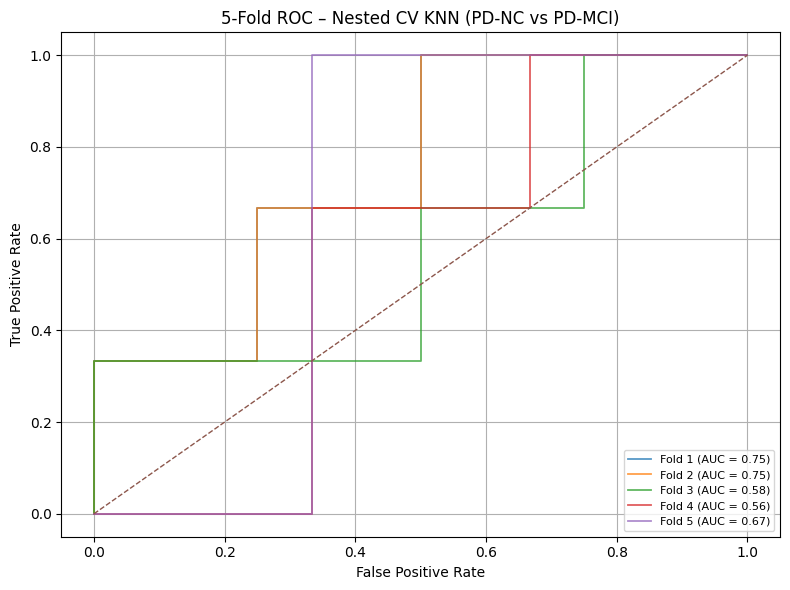

KNN Mean AUC: 0.661 ± 0.081


In [52]:
plt.figure(figsize=(8, 6))

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(pipe_knn),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_knn = grid.best_estimator_

    # ---- Extract steps
    scaler = best_knn.named_steps["scaler"]
    selector = best_knn.named_steps["select"]
    knn_model = best_knn.named_steps["clf"]

    # ---- Selected & scaled training data
    X_train_scaled = scaler.transform(X_train)
    X_train_sel = selector.transform(X_train_scaled)

    selected_features = X.columns[selector.get_support()].to_numpy()

    # ---- SHAP background + explained samples (keep small!)
    background = shap.sample(
        X_train_sel,
        min(10, X_train_sel.shape[0]),
        random_state=42
    )

    X_explain = shap.sample(
        X_train_sel,
        min(15, X_train_sel.shape[0]),
        random_state=42
    )

    explainer = shap.KernelExplainer(
        knn_model.predict_proba,
        background
    )

    shap_vals = explainer.shap_values(X_explain, nsamples=100)
    shap_vals = shap_vals[1]   # PD-MCI class

    shap_values_per_fold_knn.append(shap_vals)
    feature_names_per_fold_knn.append(selected_features)
    X_explain_per_fold_knn.append(X_explain)

    # ---- ROC
    y_prob = best_knn.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    aucs_knn.append(auc)
    selected_k.append(grid.best_params_["select__k"])

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV KNN (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"KNN Mean AUC: {np.mean(aucs_knn):.3f} ± {np.std(aucs_knn):.3f}")


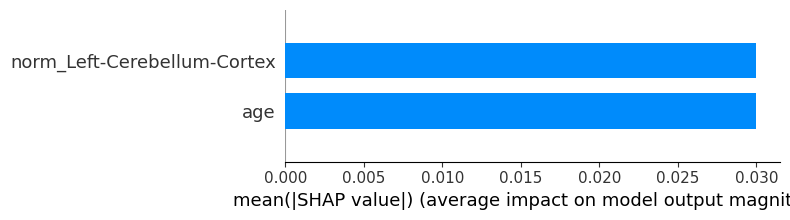

In [53]:
fold_id = 0

shap.summary_plot(
    shap_values_per_fold_knn[fold_id],
    features=None,
    feature_names=feature_names_per_fold_knn[fold_id],
    plot_type="bar",
    max_display=20,
    show=True
)


In [54]:
top_features_knn = []

for fold_shap, fold_features in zip(
        shap_values_per_fold_knn,
        feature_names_per_fold_knn):

    mean_abs = np.mean(np.abs(fold_shap), axis=0)

    top_idx = np.argsort(mean_abs)[-10:]

    top_features_knn.extend(fold_features[top_idx])

Counter(top_features_knn)


Counter({'age': 4,
         'norm_Left-Cerebellum-Cortex': 3,
         'norm_Left-Thalamus': 1,
         'norm_Right-Inf-Lat-Vent': 1,
         'norm_Brain-Stem': 1})

                       #####  Gradient Boosting  ######

In [55]:
pipe_gb = Pipeline([
    ("select", SelectKBest(score_func=f_classif)),
    ("clf", GradientBoostingClassifier(random_state=42))
])

param_grid = {
    "select__k": [15, 20, 25],
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_depth": [2],
    "clf__subsample": [0.7, 0.8]
}


In [56]:
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)


In [57]:
aucs_gb = []

shap_values_per_fold_GB = []
feature_names_per_fold_GB = []
X_train_sel_per_fold_GB = []


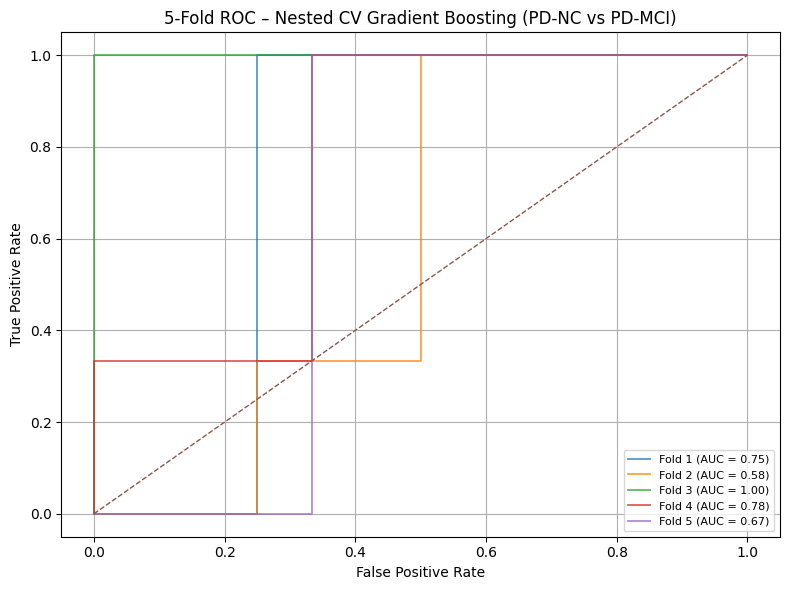

Gradient Boosting Mean AUC: 0.756 ± 0.140


In [58]:
plt.figure(figsize=(8, 6))

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(pipe_gb),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_gb = grid.best_estimator_

    # ---- Split pipeline
    selector = best_gb.named_steps["select"]
    gb_model = best_gb.named_steps["clf"]

    # ---- Selected data
    X_train_sel = selector.transform(X_train)
    selected_features = X.columns[selector.get_support()].to_numpy()

    X_train_sel_per_fold_GB.append(X_train_sel)
    feature_names_per_fold_GB.append(selected_features)

    # ---- SHAP (TreeExplainer)
    explainer = shap.TreeExplainer(gb_model)
    shap_vals = explainer.shap_values(X_train_sel)

    shap_vals = np.array(shap_vals)  # ensure ndarray
    shap_values_per_fold_GB.append(shap_vals)

    # ---- ROC
    y_prob = best_gb.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    aucs_gb.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Gradient Boosting (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Gradient Boosting Mean AUC: {np.mean(aucs_gb):.3f} ± {np.std(aucs_gb):.3f}")


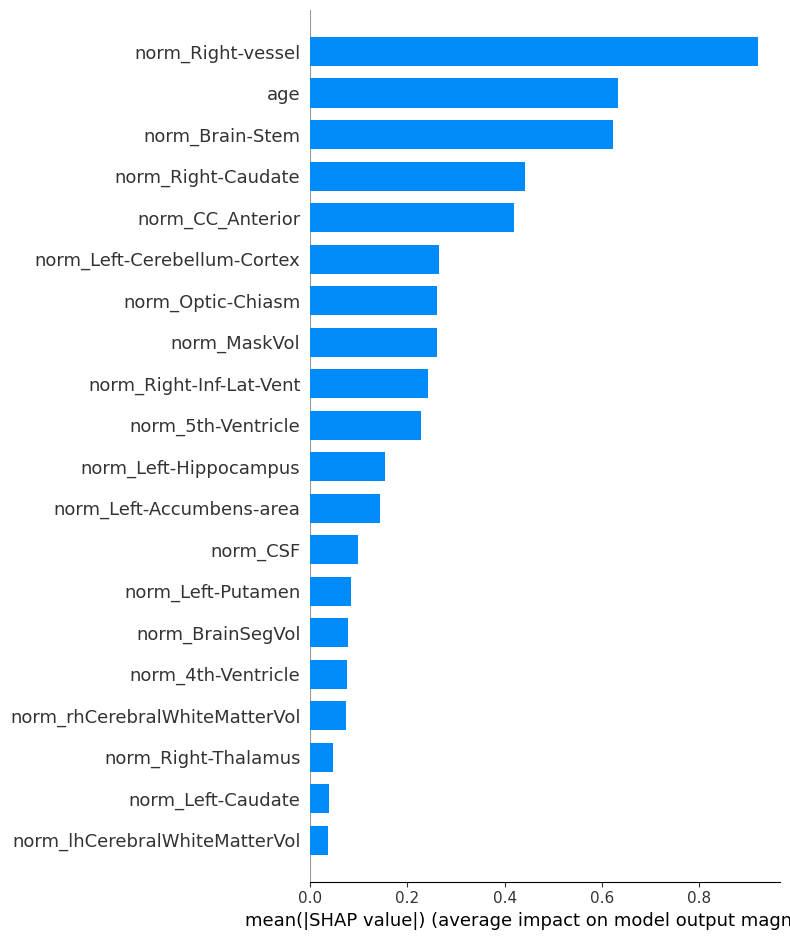

In [59]:
fold_id = 0

shap.summary_plot(
    shap_values_per_fold_GB[fold_id],
    features=None,
    feature_names=feature_names_per_fold_GB[fold_id],
    plot_type="bar",
    max_display=20,
    show=True
)


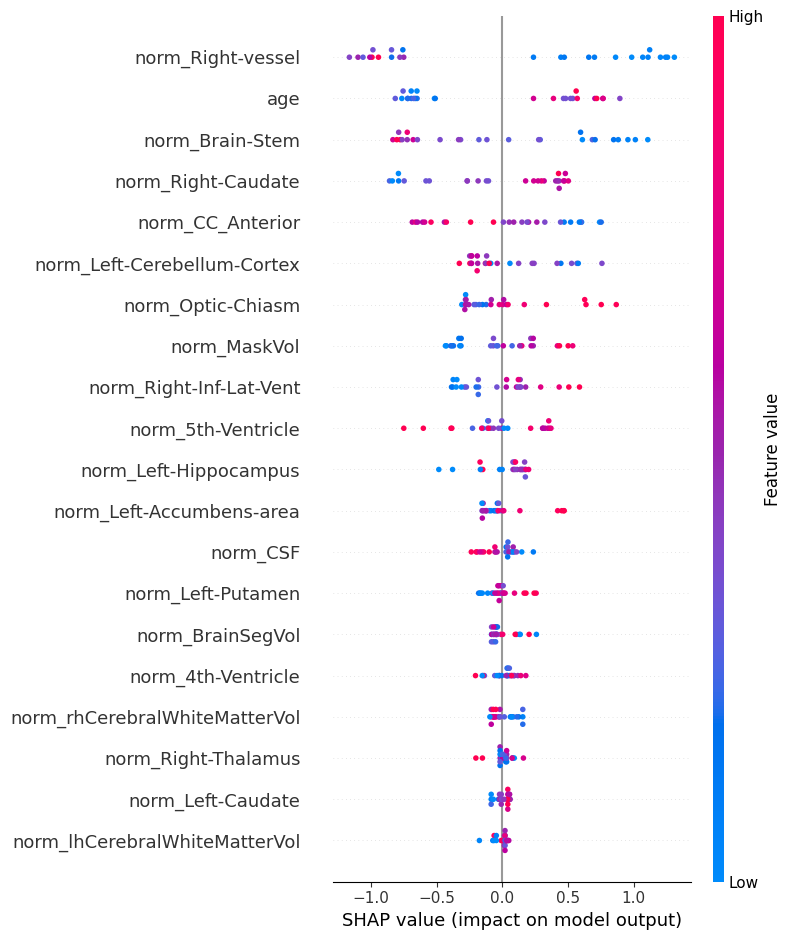

In [60]:
fold_id = 0

shap.summary_plot(
    shap_values_per_fold_GB[fold_id],
    X_train_sel_per_fold_GB[fold_id],
    feature_names=feature_names_per_fold_GB[fold_id],
    plot_type="dot",
    max_display=20,
    show=True
)


In [61]:
top_features_gb = []

for fold_shap, fold_features in zip(
        shap_values_per_fold_GB,
        feature_names_per_fold_GB):

    fold_shap = np.array(fold_shap)

    mean_abs = np.mean(np.abs(fold_shap), axis=0)

    top_idx = np.argsort(mean_abs)[-10:]

    top_features_gb.extend(fold_features[top_idx])

Counter(top_features_gb)


Counter({'norm_Brain-Stem': 5,
         'norm_Right-vessel': 5,
         'norm_Right-Inf-Lat-Vent': 4,
         'norm_Left-Cerebellum-Cortex': 4,
         'norm_Right-Caudate': 4,
         'norm_CC_Mid_Anterior': 4,
         'norm_MaskVol': 3,
         'norm_Optic-Chiasm': 3,
         'norm_CC_Anterior': 2,
         'age': 2,
         'norm_SubCortGrayVol': 2,
         'norm_4th-Ventricle': 2,
         'norm_BrainSegVolNotVent': 2,
         'norm_Right-Thalamus': 2,
         'norm_5th-Ventricle': 1,
         'norm_CSF': 1,
         'norm_Left-Thalamus': 1,
         'norm_SupraTentorialVol': 1,
         'norm_Left-Caudate': 1,
         'norm_SupraTentorialVolNotVent': 1})

                           #######  Bagging ######

100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.17it/s]


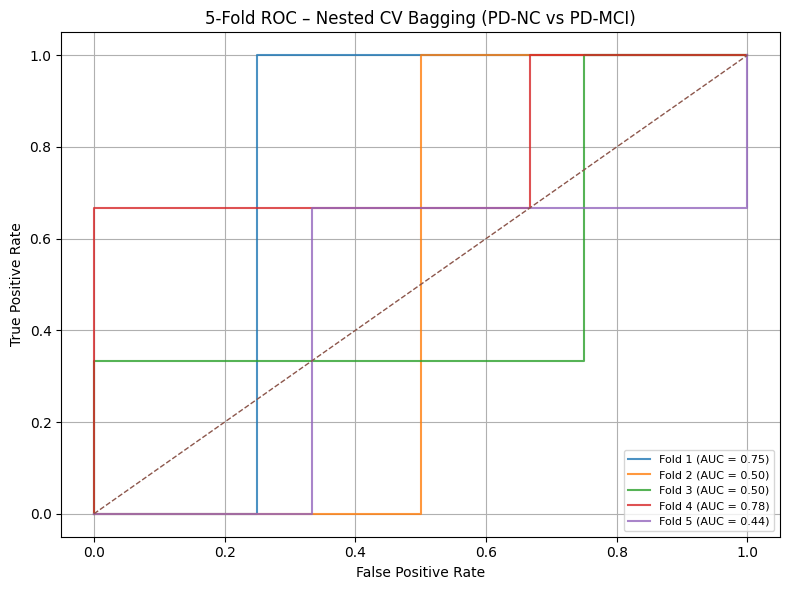

Bagging Mean AUC: 0.594 ± 0.140


In [62]:
# Bagging


plt.figure(figsize=(8, 6))

aucs_bagging = []

outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)


bag_base = BaggingClassifier(
    estimator=DecisionTreeClassifier(class_weight="balanced"),
    random_state=42
)


param_grid = {
    "n_estimators": [50, 100, 200],
    "max_samples": [0.7, 0.8, 1.0],
    "max_features": [0.7, 0.8, 1.0]
}

shap_values_per_fold_bag = []
X_train_per_fold_bag = []
feature_names_bag = X.columns

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(bag_base),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_bag = grid.best_estimator_

    y_prob = best_bag.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_bagging.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

    feature_names_per_fold_bag = []
    
    background = shap.sample(X_train, 50, random_state=42)
    
    explainer = shap.KernelExplainer(
        best_bag.predict_proba,
        background
    )
    
    X_shap = shap.sample(X_train, 100, random_state=42)
    
    shap_vals = explainer.shap_values(X_shap, nsamples=100)
    shap_vals = shap_vals[1]  # PD-MCI class
    
    shap_values_per_fold_bag.append(shap_vals)
    X_train_per_fold_bag.append(X_shap)
    feature_names_per_fold_bag.append(X_train.columns.to_numpy())

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Bagging (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Bagging Mean AUC: {np.mean(aucs_bagging):.3f} ± {np.std(aucs_bagging):.3f}")


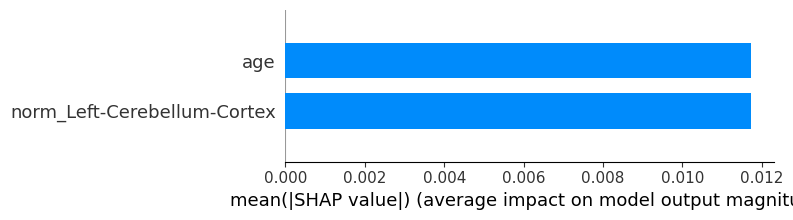

In [63]:
fold_id = 0

shap_vals = shap_values_per_fold_bag[fold_id]

shap.summary_plot(
    shap_vals,
    features=None,                  # IMPORTANT
    feature_names=feature_names_bag,
    plot_type="bar",
    max_display=20,
    show=True
)


In [64]:


top_features = []

for fold_shap in shap_values_per_fold_bag:

    fold_shap = np.array(fold_shap)

    # If binary classification SHAP list
    if isinstance(fold_shap, list):
        fold_shap = fold_shap[1]

    mean_abs = np.mean(np.abs(fold_shap), axis=0)
    mean_abs = mean_abs.flatten()

    top_idx = np.argsort(mean_abs)[-10:]

    top_features.extend(X.columns.to_numpy()[top_idx])

Counter(top_features)


Counter({'norm_Left-Cerebellum-Cortex': 5, 'age': 5})

                             ### Decision Tree ####


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5


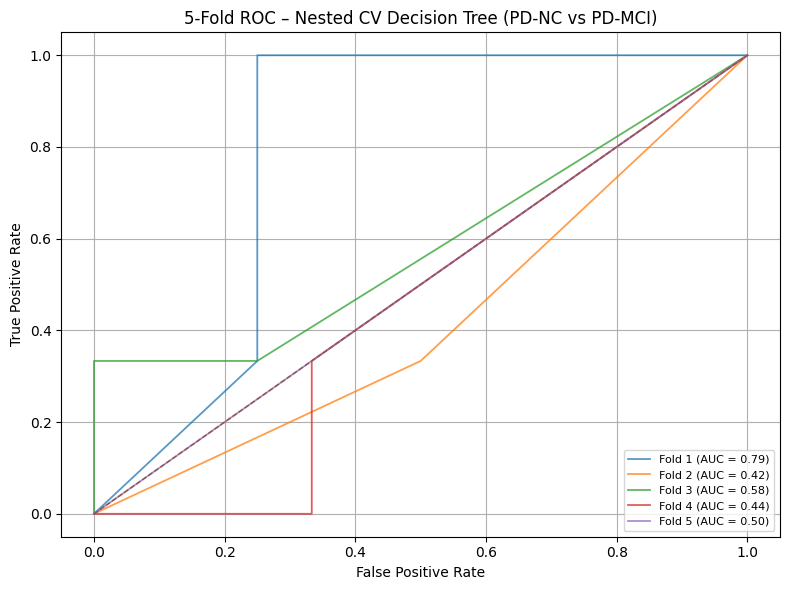

Decision Tree Mean AUC: 0.547 ± 0.135


In [94]:


# ---------------- CV SETUP ----------------
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

# ---------------- PARAM GRID ----------------
param_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

# ---------------- STORAGE ----------------
aucs_DT = []

shap_values_per_fold_DT = []      # mean(|SHAP|) per fold
feature_names_per_fold_DT = []    # feature names per fold
X_train_per_fold_DT = []          # optional, for sanity

plt.figure(figsize=(8, 6))

# ================= OUTER CV =================
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"\nFold {fold}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    dt_base = DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    )

    grid = GridSearchCV(
        estimator=clone(dt_base),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_dt = grid.best_estimator_

    # ---------------- ROC ----------------
    y_prob = best_dt.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_DT.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

    # ---------------- SHAP ----------------
    explainer = shap.TreeExplainer(best_dt)

    shap_vals = explainer.shap_values(X_train)

    # Binary classification → take positive class
    shap_vals = shap_vals[1]   # shape: (n_samples, n_features)

    # Aggregate SHAP values
    shap_vals_mean = np.mean(np.abs(shap_vals), axis=0)

    shap_values_per_fold_DT.append(shap_vals_mean)
    feature_names_per_fold_DT.append(X.columns)
    X_train_per_fold_DT.append(X_train)

# ---------------- ROC FINAL ----------------
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Decision Tree (PD-NC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Decision Tree Mean AUC: {np.mean(aucs_DT):.3f} ± {np.std(aucs_DT):.3f}")


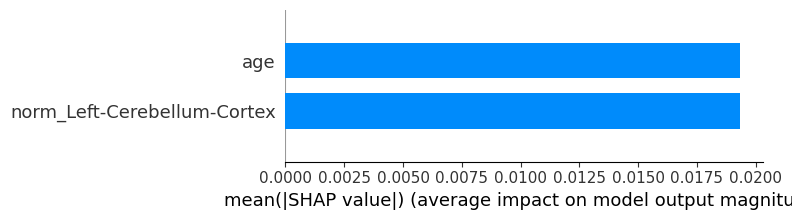

In [95]:
fold_id = 0  # choose fold

shap.summary_plot(
    shap_values_per_fold_DT[fold_id].reshape(1, -1),
    features=None,
    feature_names=feature_names_per_fold_DT[fold_id],
    plot_type="bar",
    max_display=20,
    show=True
)


In [99]:

top_features = []

for fold_shap in shap_values_per_fold_DT:

    fold_shap = np.array(fold_shap)

    # If binary classification SHAP list
    if isinstance(fold_shap, list):
        fold_shap = fold_shap[1]

    mean_abs = np.mean(np.abs(fold_shap), axis=0)
    mean_abs = mean_abs.flatten()

    top_idx = np.argsort(mean_abs)[-20:]

    top_features.extend(X.columns.to_numpy()[top_idx])

Counter(top_features)


Counter({'age': 5})

                         ##### Voting classifier ########

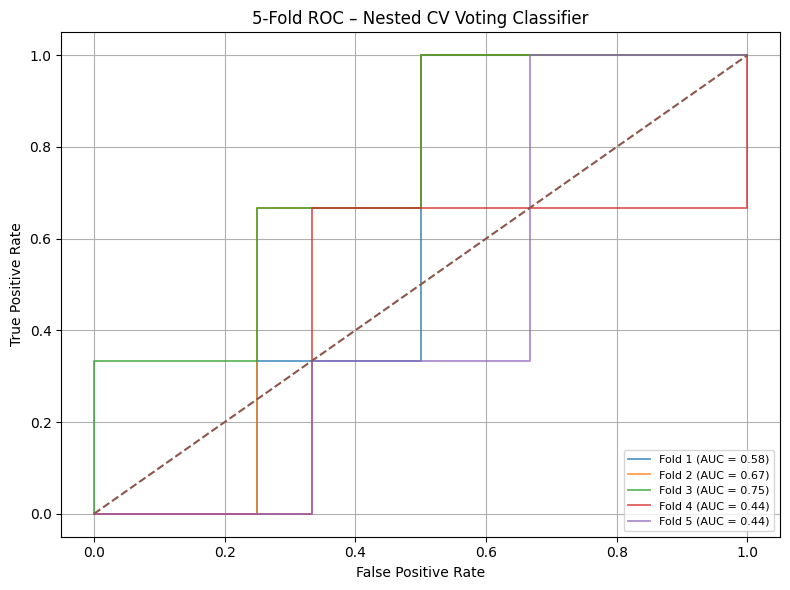

Voting Mean AUC: 0.578 ± 0.121


In [43]:
# Voting Classifier

plt.figure(figsize=(8, 6))

aucs_vote = []

outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

param_grid = {
    "rf__max_depth": [None, 5, 10],
    "rf__n_estimators": [100, 200]
}

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(voting_clf),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_vote = grid.best_estimator_

    y_prob = best_vote.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_vote.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Voting Classifier")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Voting Mean AUC: {np.mean(aucs_vote):.3f} ± {np.std(aucs_vote):.3f}")
